## SVD의 구현

* 계수가 $r$인 행렬 $A$의 특이값분해(SVD)가 $A = U\Sigma V^{\rm T}$일 때, $U$와 $V$의 $i$번째 열벡터를 각각 $\mathbf u_i$, $\mathbf v_i$, $\Sigma$의 $i$번째 대각성분을 $\sigma_i$라 할 때, 
$$ A = \sum_{i=1}^r \sigma_i \mathbf u_i\mathbf v_i^{\rm T},\quad (\sigma_1\ge \sigma_2\ge \cdots\sigma_r>0)$$


* $B=A^{\rm T}A$라 할 때, $B = \sum_{i=1}^r \sigma_i^2 \mathbf v_i\mathbf v_i^{\rm T}$이므로 $B\mathbf v_i= \sigma_i^2 \mathbf v_i$이고 이로부터 $B^k\mathbf v_i = \sigma_i^{2k}\mathbf v_i$


* 따라서 임의의 $\mathbf x =\sum_{i=1}^r c_i\mathbf v_i$에 대하여 $B^k\mathbf x = \sum_{i=1}^r c_i \sigma_i^{2k}\mathbf v_i$


* $\sigma_1$이 $\sigma_i \ (i\neq 1)$보다 큰 경우 
$$\displaystyle{\lim_{k\to \infty}\dfrac {B^{k}\mathbf x}{||B^{k}\mathbf x||}=\lim_{k\to \infty}\sum_{i=1}^r \dfrac{c_i\sigma_i^{2k}}{\sqrt{c_1^2\sigma_1^{4k}+\cdots c_r^2\sigma_r^{4k}}}\mathbf v_i}= \mathbf v_1 $$



* 한편 $A\mathbf v_i = \sigma_i \mathbf u_i$이므로 $\mathbf v_i$를 알면 $\sigma_i = ||A\mathbf v_i||$이고 
$\displaystyle{\mathbf u_i = \dfrac{A\mathbf v_i}{||A\mathbf v_i||}}$

* $\mathbf v_1,\ \mathbf u_1,\ \sigma_1$을 구하고 나면 
$$B = (A-\sigma_1\mathbf u_1\mathbf v_1^{\rm T})^{\rm T}(A-\sigma_1\mathbf u_1\mathbf v_1^{\rm T})= \sum_{i=2}^r \sigma_i^2\mathbf v_i \mathbf v_i^{\rm T}$$
에 대해 위 과정을 반복하면 $\sigma_2>\sigma_3$인 경우 $\mathbf v_2,\ \mathbf u_2,\ \sigma_2$를 구할 수 있고, 이를 계속 반복하여 $A$에 대한 SVD를 구할 수 있음



* 특이값 사이의 비가 $1$에 가까운 경우 $\mathbf v_i$로 수렴하는데 시간이 많이 걸림



* 일반적으로는 행렬의 왼쪽에 Householder reflection을 적용하여 QR 분해하는 아이디어와 유사하게 행렬의 양쪽에서 Householder reflection을 적용하여 SVD를 구하는 방법을 많이 사용



* 이 강의에서는 Householder reflection을 이용한 QR 분해까지 다룸




In [1]:
import numpy as np
from numpy.linalg import norm

def randomUnitVector(n):
    unnormalized = np.random.randn(n)
    return unnormalized / np.sqrt(np.sum(unnormalized ** 2))


def svd1d(A, epsilon=1e-10, verbose=False):
    ''' The one-dimensional SVD '''

    n, m = A.shape
    x = randomUnitVector(min(n,m))
    lastV = None
    currentV = x

    if n > m:
        B = A.T @ A
    else:
        B = A @ A.T

    iterations = 0
    while True:
        iterations += 1
        lastV = currentV
        currentV = B @ lastV
        currentV = currentV / norm(currentV)

        if np.abs(np.dot(currentV, lastV)) > 1 - epsilon: # 두 단위벡터 사이의 각
            if verbose:
                print("converged in {} iterations!".format(iterations))
            return currentV


def svd0(A, k=None, epsilon=1e-10, verbose=False):
    '''
        A의 특이값분해를 계산
        입력: A는 행렬, k는 계산하려는 특이값의 개수 (k가 None이면 full-rank)
    '''
    A = np.array(A, dtype=float)
    n, m = A.shape
    svdList = []
    if k is None:
        k = min(n, m)

    for i in range(k):
        tempMatrix = A.copy()

        for singularValue, u, v in svdList[:i]:
            tempMatrix -= singularValue * np.outer(u, v) # np.outer(u,v)는 u[:,np.newaxis]@ v[:,np.newaxis].T와 동일

        if n > m:
            v = svd1d(tempMatrix, epsilon=epsilon, verbose=verbose)  # next singular vector
            u_unnormalized = A @ v
            sigma = norm(u_unnormalized)  # next singular value
            u = u_unnormalized / sigma
        else:
            u = svd1d(tempMatrix, epsilon=epsilon, verbose = verbose)  # next singular vector
            v_unnormalized = A.T @ u
            sigma = norm(v_unnormalized)  # next singular value
            v = v_unnormalized / sigma

        svdList.append((sigma, u, v))

    sv, RowU, RowV = [np.array(x) for x in zip(*svdList)] # A = U S V^T에서 uRow는 U^T, vRow는 V^T
    return sv, RowU.T, RowV

In [2]:
def svd(A, k=None, epsilon=1e-10, verbose=False):
    '''
        A의 특이값분해를 계산
        입력: A는 행렬, k는 계산하려는 특이값의 개수 (k가 None이면 full-rank)
    '''
    A = np.array(A, dtype=float)
    n, m = A.shape
    
    if k is None:
        k = min(n, m)
    
    RowU = np.zeros((k,n))
    RowV = np.zeros((k,m))
    sv = np.zeros(k)

    tempMatrix = A.copy()
    
    for i in range(k):
        if n > m:
            RowV[i] = svd1d(tempMatrix, epsilon=epsilon, verbose=verbose)  # next singular vector
            u_unnormalized = A @ RowV[i]
            sv[i] = norm(u_unnormalized)  # next singular value
            RowU[i] = u_unnormalized / sv[i]
        else:
            RowU[i] = svd1d(tempMatrix, epsilon=epsilon, verbose = verbose)  # next singular vector
            v_unnormalized = A.T @ u
            sv[i] = norm(v_unnormalized)  # next singular value
            RowV[i] = v_unnormalized / sv[i]
            
        tempMatrix -= sv[i] * np.outer(RowU[i], RowV[i]) # np.outer(u,v)는 u[:,np.newaxis]@ v[:,np.newaxis].T와 동일

    return sv, RowU.T, RowV

In [3]:
A = np.array([
    [2, 5, 3],
    [1, 2, 1],
    [4, 1, 1],
    [3, 5, 2],
    [5, 3, 1],
    [4, 5, 5],
    [2, 4, 2],
    [2, 2, 5]
], dtype='float64')

In [4]:
s, u, vt = svd0(A, verbose=True)

converged in 7 iterations!
converged in 24 iterations!
converged in 2 iterations!


In [5]:
s

array([15.09626916,  4.30056855,  3.40701739])

In [6]:
u

array([[ 0.39458532, -0.23922898, -0.35446529],
       [ 0.15830233, -0.03054625, -0.15299841],
       [ 0.22155189,  0.52085559,  0.39336229],
       [ 0.39692632,  0.08649776, -0.41052675],
       [ 0.34630242,  0.64128807,  0.07384473],
       [ 0.53347454, -0.19169038,  0.1994884 ],
       [ 0.31660465, -0.06109249, -0.30599682],
       [ 0.32840235, -0.4597131 ,  0.6235359 ]])

In [7]:
vt

array([[ 0.54184749,  0.67070999,  0.50650706],
       [ 0.75151584, -0.11679387, -0.64929433],
       [ 0.37633128, -0.73246658,  0.56733365]])

In [8]:
A_rec = (u*s) @ vt

In [9]:
ss, uu, vvt = svd(A, verbose=True)

converged in 7 iterations!
converged in 26 iterations!
converged in 2 iterations!


In [10]:
(uu * ss) @ vvt

array([[2., 5., 3.],
       [1., 2., 1.],
       [4., 1., 1.],
       [3., 5., 2.],
       [5., 3., 1.],
       [4., 5., 5.],
       [2., 4., 2.],
       [2., 2., 5.]])

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
kcha = plt.imread('kcha.png')
kcha2 = np.mean(kcha, axis=2)

In [13]:
s, u, vt = svd(kcha2, k=40, verbose=True)

converged in 6 iterations!
converged in 18 iterations!
converged in 16 iterations!
converged in 38 iterations!
converged in 75 iterations!
converged in 58 iterations!
converged in 55 iterations!
converged in 32 iterations!
converged in 83 iterations!
converged in 64 iterations!
converged in 39 iterations!
converged in 364 iterations!
converged in 53 iterations!
converged in 90 iterations!
converged in 42 iterations!
converged in 348 iterations!
converged in 125 iterations!
converged in 39 iterations!
converged in 111 iterations!
converged in 125 iterations!
converged in 53 iterations!
converged in 99 iterations!
converged in 76 iterations!
converged in 59 iterations!
converged in 152 iterations!
converged in 95 iterations!
converged in 81 iterations!
converged in 190 iterations!
converged in 132 iterations!
converged in 88 iterations!
converged in 106 iterations!
converged in 123 iterations!
converged in 389 iterations!
converged in 99 iterations!
converged in 110 iterations!
converged

In [14]:
s[:40]

array([252.61520125,  62.56975256,  45.82912774,  30.0383472 ,
        26.26540451,  24.81834685,  23.0480504 ,  21.18730096,
        17.89815421,  16.73109378,  15.21898575,  13.21814305,
        12.97294387,  11.87958297,  11.18342258,   9.95427121,
         9.86028132,   9.44411885,   8.16796596,   7.87009203,
         7.6542539 ,   7.0822825 ,   6.79409593,   6.36853085,
         5.96147113,   5.8306243 ,   5.55874958,   5.25989871,
         5.13229008,   5.02113177,   4.77536371,   4.60539478,
         4.4880976 ,   4.44561094,   4.2655145 ,   4.11910536,
         3.95594465,   3.75898026,   3.73092678,   3.65041198])

In [15]:
kcha_rec = (u*s) @ vt

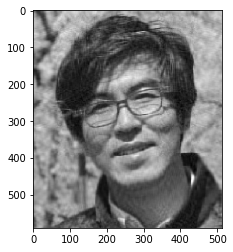

In [16]:
plt.imshow(kcha_rec, cmap='gray')

In [17]:
from time import time

In [18]:
start1 = time()
s, u, vt = svd0(kcha2, k=100)
print(time()-start1)

13.199236631393433


In [19]:
start2 = time()
s, u, vt = svd(kcha2, k=100)
print(time()-start2)

1.7513148784637451
